In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
from torchsummary import summary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# prepare data 

In [77]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([2ㅇ24, 224], antialias=True)
])

In [78]:
train = datasets.ImageFolder(root='../../data/imagenet-mini/train/', transform=transform)
test = datasets.ImageFolder(root='../../data/imagenet-mini/val/', transform=transform)

In [108]:
random_indices = np.random.choice(range(1000),500, replace=False)
temp=[]
for inx, label in enumerate(train.targets):
    if label in random_indices:
        temp.append(inx)
    else:
        pass
temp_test=[]
for inx, label in enumerate(test.targets):
    if label in random_indices:
        temp_test.append(inx)
    else:
        pass

In [109]:
subset = torch.utils.data.Subset(train, indices=temp)
subset_test = torch.utils.data.Subset(test, indices=temp_test)

In [110]:
len(train)

34745

In [111]:
len(subset)

17459

In [10]:
train_loader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=True, num_workers=10)
test_loader = torch.utils.data.DataLoader(subset_test, batch_size=32, shuffle=True, num_workers=10)

In [11]:
# train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=10)
# test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True, num_workers=10)

## iterating data 

In [12]:
img, label = (next(iter(train_loader)))

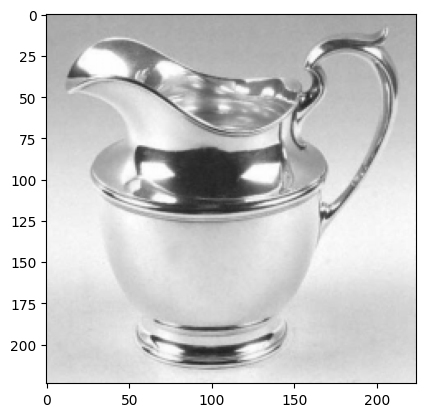

In [13]:
plt.imshow(np.transpose(img[0], (1, 2, 0)))

# Define model

In [50]:
class Resblock(nn.Module):
    def __init__(self, ksize=3, channel_in=64, channel_out=64, init_block = False, USE_BATCH_NORM=True):
        super().__init__()
        self.shortcut = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=1, stride=2)
        self.layers = []
        self.init_block = init_block
        if self.init_block==True:
            stride_init = 2
        else:
            stride_init = 1
            #잔차계산을 위해 모듈화시킬것
        self.layers.append(nn.Conv2d(in_channels=channel_in, out_channels=channel_out,
                            kernel_size=ksize,
                             stride=stride_init,
                             padding=ksize//2))
        self.layers.append(nn.BatchNorm2d(channel_out))
        self.layers.append(nn.ReLU(True))

        self.layers.append(nn.Conv2d(in_channels=channel_out, out_channels=channel_out,
                            kernel_size=ksize,
                             stride=1,
                             padding=ksize//2))
        self.layers.append(nn.BatchNorm2d(channel_out))
#             self.layers.append(nn.ReLU(True))  #use relu after residual sum
        self.resblock = nn.Sequential(*self.layers)
        
        
    def forward(self, x):
        if self.init_block==True:
            return F.relu(self.resblock(x) + self.shortcut(x))
        else:
            return F.relu(self.resblock(x))

In [51]:
class ResNet(nn.Module):
    def __init__(self, name="resnet", xdim=[3, 224, 224], ksize=3, cdims=[64, 128, 256, 512], layeriter=[3,4,6,3],
                hdim=1000, USE_BATCH_NORM=True):
        super().__init__()
        self.name = name
        self.xdim = xdim    #means C, W, H
        self.cdims = cdims  #Channels
        self.hdim = hdim    #Output dimension
        self.ksize = ksize
        self.USE_BATCH_NORM = USE_BATCH_NORM
        
        #Convnet
        self.layers=[]
        prev_cdim = self.xdim[0]
        self.layers.append(nn.Conv2d(in_channels=prev_cdim, out_channels=64,
                                    kernel_size=7,
                                    stride=2,
                                    padding=7//2))
        self.layers.append(nn.BatchNorm2d(64))
        self.layers.append(nn.ReLU(True))  #no maxpool and dropout
        self.layers.append(nn.MaxPool2d(2))
        prev_cdim=64
        
#         layers=[]
        for index, cdim in enumerate(self.cdims):
            iteration = layeriter[index]
            for i in range(iteration):
                if i==0:
                    init_block=True
                    if cdims[index]==64:
                        init_block=False
                else:
                    init_block=False
                    
                    #잔차계산을 위해 모듈화시킬것
                self.layers.append(Resblock(channel_in=prev_cdim, channel_out=cdims[index],
                                           init_block=init_block))
                prev_cdim = cdims[index]
                    
        
        self.layers.append(nn.AdaptiveAvgPool2d((1, 1))) #넣어준 인자만큼의 space로 채널을 평균 풀링해주는듯?
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(prev_cdim, hdim, bias=True))
        
        self.net = nn.Sequential(*self.layers)     

        
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            
            
    def forward(self, x):
        return self.net(x)
    
resnet = ResNet(name="resnet", xdim=[3, 224, 224], ksize=3, cdims=[64, 128, 256, 512], layeriter=[3,4,6,3],
        hdim=1000, USE_BATCH_NORM=True).to(device)    #hdim으로 출력층 개수 조절

In [16]:
resnet

ResNet(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Resblock(
      (shortcut): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (resblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (5): Resblock(
      (shortcut): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (resblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [17]:
summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Resblock-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,928
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

## Check Parameters

In [18]:
# np.set_printoptions(precision=3)
# n_param = 0
# for p_idx,(param_name,param) in enumerate(resnet.named_parameters()):
#     if param.requires_grad:
#         param_numpy = param.detach().cpu().numpy() # to numpy array 
#         n_param += len(param_numpy.reshape(-1))
#         print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
#         print ("    val:%s"%(param_numpy.reshape(-1)[:5]))   #1차원으로 만든다음 앞의 5개만 가져오는 head()와 비슷한 역활
# print ("Total number of parameters:[%s]."%(format(n_param,',d')))

## Simple Forward Path of the CNN Model

In [52]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,3,224, 224)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = resnet.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[0.162, 0.443, 0.715,  ..., 0.116, 0.048, 0.973],
          [0.431, 0.777, 0.638,  ..., 0.404, 0.703, 0.531],
          [0.941, 0.534, 0.255,  ..., 0.672, 0.774, 0.206],
          ...,
          [0.618, 0.928, 0.299,  ..., 0.641, 0.237, 0.669],
          [0.690, 0.157, 0.030,  ..., 0.258, 0.299, 0.635],
          [0.571, 0.483, 0.557,  ..., 0.080, 0.360, 0.947]],

         [[0.253, 0.589, 0.035,  ..., 0.060, 0.412, 0.282],
          [0.197, 0.041, 0.091,  ..., 0.871, 0.753, 0.281],
          [0.397, 0.665, 0.135,  ..., 0.753, 0.736, 0.997],
          ...,
          [0.785, 0.171, 0.002,  ..., 0.254, 0.954, 0.757],
          [0.110, 0.869, 0.619,  ..., 0.058, 0.860, 0.121],
          [0.230, 0.107, 0.682,  ..., 0.096, 0.298, 0.331]],

         [[0.238, 0.237, 0.766,  ..., 0.554, 0.592, 0.255],
          [0.170, 0.406, 0.213,  ..., 0.618, 0.390, 0.260],
          [0.287, 0.078, 0.902,  ..., 0.801, 0.746, 0.802],
          ...,
          [0.073, 0.363, 0.511,  ..., 0.2

In [53]:
print(x_torch.shape, y_torch.shape)

torch.Size([2, 3, 224, 224]) torch.Size([2, 1000])


## Define optimizer

In [54]:
loss = nn.CrossEntropyLoss()
optm = optim.Adam(resnet.parameters(), lr=0.001)

# Train 

In [85]:
print ("Start training.")
resnet.init_param() # initialize parameters
# resnet.train() # to train mode 
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    resnet.train()
    loss_sum = 0
    acc_sum = 0
    for batch_in,batch_out in train_loader:
        batch_out = torch.Tensor(batch_out)
        y_pred = resnet.forward(batch_in.view(-1,3,224,224).to(device))
        loss_out = loss(y_pred,batch_out.to(device))

        optm.zero_grad()
        loss_out.backward()
        optm.step()

        pred = torch.argmax(y_pred, 1).to("cpu")
        loss_sum += loss_out.item()
        acc_sum += torch.sum(pred == batch_out)
    train_acc = acc_sum/len(train_loader)
    train_loss = loss_sum/len(train_loader)
    
    loss_sum = 0
    acc_sum = 0
    resnet.eval()
    with torch.no_grad():
        for batch_in,batch_out in test_loader:
            y_pred = resnet.forward(batch_in.view(-1,3,224,224).to(device))
            loss_out = loss(y_pred,batch_out.to(device))
            pred = torch.argmax(y_pred, 1).to("cpu")

            loss_sum += loss_out.item()
            acc_sum += torch.sum(pred == batch_out)
        val_acc = acc_sum/len(test_loader)
        val_loss = loss_sum/len(test_loader)
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_acc, val_acc = train_acc*100, val_acc*100
        print(f"Epoch: [{epoch}/{EPOCHS}], Loss: [train: {train_loss:.3f}/val: {val_loss:.3f}],Acc: [train: {train_acc:.3f}/val: {val_acc:.3f}])")
print ("Done")

Start training.
Epoch: [0/10], Loss: [train: 6.113/val: 5.997],Acc: [train: 18.854/val: 10.638])
Epoch: [1/10], Loss: [train: 5.923/val: 5.949],Acc: [train: 25.060/val: 21.277])
Epoch: [2/10], Loss: [train: 5.859/val: 5.921],Acc: [train: 30.310/val: 21.277])
Epoch: [3/10], Loss: [train: 5.823/val: 5.889],Acc: [train: 30.072/val: 21.277])
Epoch: [4/10], Loss: [train: 5.755/val: 5.825],Acc: [train: 38.425/val: 21.277])
Epoch: [5/10], Loss: [train: 5.699/val: 5.810],Acc: [train: 35.561/val: 29.787])
Epoch: [6/10], Loss: [train: 5.640/val: 5.818],Acc: [train: 44.630/val: 34.043])
Epoch: [7/10], Loss: [train: 5.589/val: 5.748],Acc: [train: 48.210/val: 29.787])
Epoch: [8/10], Loss: [train: 5.543/val: 5.781],Acc: [train: 53.699/val: 40.426])
Epoch: [9/10], Loss: [train: 5.495/val: 5.671],Acc: [train: 65.394/val: 44.681])
Done


1에폭 18분 걸림  
n_worker=10기준 7분